<a href="https://colab.research.google.com/github/Michal287/defect_detection/blob/main/GKN_Tulips_SingleLabel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q split_folders

# Imports

In [ ]:
#os
from google.colab import drive
import os
from datetime import datetime

#tensorflow tools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint

#tensorflow architecture
from tensorflow.keras.layers import Conv2D, MaxPool2D, Rescaling, Dense, Dropout, LayerNormalization, Flatten, Resizing, Rescaling, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model

#agumentation
import albumentations as A

#tensorboard
%load_ext tensorboard

#cv2
import cv2
from google.colab.patches import cv2_imshow

#sklearn
from sklearn.preprocessing import MultiLabelBinarizer

#tools
import random
import numpy as np
import splitfolders

#plt
import matplotlib.pyplot as plt

# Connect to google drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Checking GPU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Download images from google drive

In [ ]:
!unzip -q /content/drive/MyDrive/images_multilabel.zip

# Settings

In [ ]:
image_width, image_height = 510, 510
IMG_SIZE = (510, 510)
BATCH_SIZE = 4
EPOCHS = 30
data_extend_ratio = 1

In [ ]:
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=.4),
    A.HueSaturationValue(val_shift_limit=(-20, 20), p=.4),
    A.Blur(blur_limit=2, p=.4),
    A.VerticalFlip(p=.7),
    A.HorizontalFlip(p=.7),
])

image = cv2.imread('images/brak_kanalka/image_1004.jpg')
image = cv2.resize(image, (image_width, image_height))
image_aug = transform(image=image)["image"]
cv2_imshow(image_aug)
image_aug.shape

In [ ]:
if not os.path.isdir('processed_images'):
  os.mkdir('processed_images')

files = []

for dir in os.listdir("images"):
  if not os.path.isdir('processed_images/' + dir):
    os.mkdir('processed_images/' + dir)

  for file in os.listdir(f"images/{dir}"):
      files.append(f"images/{dir}/{file}")

In [ ]:
for file in files:
  try:
    image = cv2.imread(file)
    # image = cv2.resize(image, (image_width, image_height))
    cv2.imwrite("processed_images/" + "/".join(file.split("/")[1:]), image)

    for i in range(data_extend_ratio):
      dir, filename = file.split("/")[1:][0], file.split("/")[1:][1]
      filename = filename.split(".")
      filename, ext = filename[0], filename[1]

                                  # if int(dir) in [4]:
                                  #   if not random.randint(0, 2):
                                  #     image_aug = transform(image=image)["image"]
                                  #     cv2.imwrite(f"processed_images/{dir}/{filename}_{i+1}.{ext}", image_aug)
                                  #   else:
                                  #     continue

                                  # elif int(dir) in [7]:
                                  #   if not random.randint(0, 1):
                                  #     image_aug = transform(image=image)["image"]
                                  #     cv2.imwrite(f"processed_images/{dir}/{filename}_{i+1}.{ext}", image_aug)
                                  #   else:
                                  #     continue
          
      
      image_aug = transform(image=image)["image"]
      cv2.imwrite(f"processed_images/{dir}/{filename}_{i+1}.{ext}", image_aug)
  except Exception:
    print(file)

images/nieobrobiony_srodek/6
images/nieobrobiony_srodek/7


In [ ]:
processed_files = []

# Count all files
for dir in os.listdir("processed_images"):
  for file in os.listdir(f"processed_images/{dir}"):
      processed_files.append(f"processed_images/{dir}/{file}")

len(processed_files)

5262

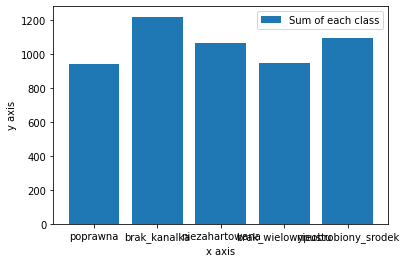

In [ ]:
labels = [i for i in os.listdir("processed_images")]
sum_files = []

for i in os.listdir("processed_images"):
  sum_files.append(len(os.listdir(f"processed_images/{i}")))

plt.bar(labels, sum_files, label="Sum of each class")
plt.plot()

plt.xlabel("x axis")
plt.ylabel("y axis")
plt.legend()
plt.show()

In [ ]:
test_agumentation = [random.randint(1, len(processed_files)) for i in range(10)]

for i in test_agumentation:
  cv2_imshow(cv2.imread(processed_files[i]))

In [ ]:
splitfolders.ratio("processed_images", output="data", seed=1337, ratio=(.75, .2, .05), group_prefix=None)

Copying files: 8832 files [00:01, 5166.21 files/s]


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory("data/train",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
                                                            
validation_dataset = tf.keras.utils.image_dataset_from_directory("data/val",
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
                                                            

print('\n\nNumber of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset).numpy())

Found 6624 files belonging to 7 classes.
Found 1764 files belonging to 7 classes.


Number of training batches: 1656
Number of validation batches: 441


# Custom Model

In [ ]:
model = Sequential([
        Resizing(128, 128, input_shape=(510, 510, 3)),
        Rescaling(1./255),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        MaxPool2D(pool_size=(2, 2)),

        GlobalAveragePooling2D(),

        Dense(512, activation='relu'),

        Dense(7, activation='sigmoid'),
    ])

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_25 (Resizing)      (None, 128, 128, 3)       0         
                                                                 
 rescaling_28 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_104 (Conv2D)         (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_89 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_105 (Conv2D)         (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 32, 32, 128)      0         
 g2D)                                                

In [ ]:
dt = datetime.now().strftime('%d_%m_%Y_%H_%M')
filepath = os.path.join('output', 'model_' + dt + '.hdf5')
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)

In [ ]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=50, callbacks=[checkpoint, tensorboard_callback])

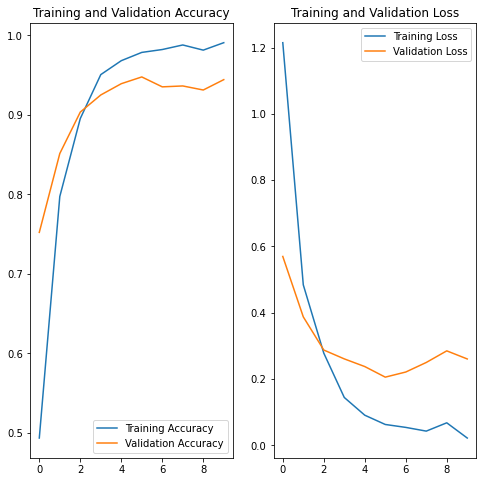

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ResNet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

resnet50 = ResNet50(include_top=False, #ostatnie warstwy zagęszczone, specyficzne dla zbioru, nie zostają załadowane
                    weights='imagenet',
                    input_shape=(510,510,3),
                    pooling=True, classes=7)

for layer in resnet50.layers:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(resnet50)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
Dropout(0.5),
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 16, 16, 2048)      23587712  
                                                                 
 flatten_14 (Flatten)        (None, 524288)            0         
                                                                 
 dense_33 (Dense)            (None, 64)                33554496  
                                                                 
 dense_34 (Dense)            (None, 2)                 130       
                                                                 
Total params: 57,142,338
Trainable params: 33,554,626
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
dt = datetime.now().strftime('%d_%m_%Y_%H_%M')
filepath = os.path.join('output', 'model_' + dt + '.hdf5')
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=50, callbacks=[checkpoint, tensorboard_callback])

Epoch 1/50
126/126 [==============================] - 11s 66ms/step - loss: 11.0847 - accuracy: 0.5418 - val_loss: 0.8752 - val_accuracy: 0.5591
Epoch 2/50
126/126 [==============================] - 8s 62ms/step - loss: 0.6752 - accuracy: 0.6135 - val_loss: 0.7459 - val_accuracy: 0.6142
Epoch 3/50
126/126 [==============================] - 8s 62ms/step - loss: 0.6224 - accuracy: 0.6474 - val_loss: 0.6136 - val_accuracy: 0.6614
Epoch 4/50
126/126 [==============================] - 7s 53ms/step - loss: 0.5899 - accuracy: 0.6534 - val_loss: 0.6373 - val_accuracy: 0.6457
Epoch 5/50
126/126 [==============================] - 8s 64ms/step - loss: 0.5302 - accuracy: 0.6853 - val_loss: 0.7394 - val_accuracy: 0.6772
Epoch 6/50
126/126 [==============================] - 7s 55ms/step - loss: 0.4585 - accuracy: 0.6992 - val_loss: 0.4856 - val_accuracy: 0.6457
Epoch 7/50
126/126 [==============================] - 8s 64ms/step - loss: 0.4472 - accuracy: 0.7351 - val_loss: 0.4854 - val_accuracy: 0.70

KeyboardInterrupt: ignored

# VGG16

In [ ]:
model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    pooling=True,
    classes=7,
    classifier_activation='softmax',
    input_shape = (224, 224, 3)
)

In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential([
        model,
        
        Flatten(),

        Dense(1024, activation='relu'),
        Dense(7, activation='softmax')
    ])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 1024)              25691136  
                                                                 
 dense_14 (Dense)            (None, 7)                 7175      
                                                                 
Total params: 45,722,695
Trainable params: 45,722,695
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
dt = datetime.now().strftime('%d_%m_%Y_%H_%M')
filepath = os.path.join('output', 'model_' + dt + '.hdf5')
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)

In [ ]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=70, callbacks=[checkpoint, tensorboard_callback])

In [ ]:
import pickle

print('Model: ' + 'output/model_' + dt + '.hdf5')
print('[INFO] Loading model...')
model = load_model('output/model_'+dt+'.hdf5')

Model: output/model_04_01_2023_10_46.hdf5
[INFO] Loading model...


In [ ]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform([str(i) for i in labels])
print(f'[INFO] Etykiety: {mlb.classes_}')

print('[INFO] Eksport etykiet do pliku...')
with open(r'output/mlb.pickle', 'bw') as file:
    pickle.dump(mlb, file)

[INFO] Etykiety: ['0' '1' '2' '3' '4' '5' '6']
[INFO] Eksport etykiet do pliku...


In [ ]:
test_images = []

for dir in os.listdir("data/test"):
  for file in os.listdir(f"data/test/{dir}"):
      test_images.append(f"data/test/{dir}/{file}")

random.shuffle(test_images)

In [ ]:
class_mapping = {
    '1': "Brak wielowypustu",
    '2': "Niezahartowana",
    '3': "Niezahartowana / Brak kanalka",
    '4': "Poprawna",
    '5': "Brak kanalka",
    '6': "Srodek Nieobrobiony",
    '7': "Srodek Nieobrobiony / Brak kanalka"
}

for path in test_images[:30]:
  image = cv2.imread(path)
  nativ = image.copy()
  image = image.reshape(1, 510, 510, 3)
  y_pred = model.predict(image)[0]

  labels = dict(enumerate(mlb.classes_))
  idxs = np.argsort(y_pred)[::-1]

  real_class = path.split("/")[2]

  pred = str(int(labels[idxs[0]]) + 1)

  if real_class == pred:
    color = (0, 255, 0)
  else:
    color = (0, 0, 255)

  cv2.putText(nativ, f"Class predcited: {class_mapping[pred]} ({pred}) - {round((y_pred[idxs[0]] * 100), 2)}%",
                                  (10, 30),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
  
  cv2.putText(nativ, f"Class real: {class_mapping[real_class]} ({real_class})",
                                  (10, 70),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

  cv2_imshow(nativ)